# The 2D Ising Model

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 100

from matplotlib import colors as mcolors        # Packages to define custom colormaps
from matplotlib.animation import FuncAnimation  # and animations

from numba import njit         # Import this if you're using @njit to speed up your code
from tqdm import tqdm          # This is a very cool package that allows you to see a "progress bar" to know how far a loop has progressed

In [2]:
@njit                                     # Once you've written your code using only numpy arrays, you can choose to speed it up using this command
def oneMCS(spins, beta, h, energy, J=1):
    '''
    Perform a single Monte-Carlo sweep on a lattice of spins. The function accepts an array of spins, the 
    inverse temperature, and the external magnetic field. The total system energy is also accepted in order
    to compute the change in energy more efficiently.
    
    Parameters:
    -----------
    • spins  : A 2D numpy array of L x L elements storing the L**2 spins.
    • beta   : The inverse temperature at which to simulate the lattice.
    • h      : Value of the external magnetic field.
    • energy : The total energy of the supplied spin lattice.
    • J      : The coupling constant (by default, this is 1).
    
    Returns:
    --------
    The function returns one value:
    • spins  : The newly updated spin lattice. 
    • energy : The total energy of the newly updated spin lattice.
    '''
    
    L = np.shape(spins)[0]
    N = L**2
    for i in range(N):
        p,q = np.random.randint(L), np.random.randint(L)          # Choose a random spin
        
        this_energy = -J*spins[p][q]*(spins[(p-1)][q] + spins[(p+1)%L][q] + spins[p][(q-1)] + spins[p][(q+1)%L]) - h*spins[p][q] # Compute its energy enforcing periodic boundary conditions
        
        new_energy  = - this_energy
        
        dE = new_energy - this_energy

        if(dE<=0 or np.random.uniform(0,1)<np.exp(-beta*dE)):  # If a flip should happen
            spins[p][q] = -spins[p][q]                         # Flip the spin
            energy += dE                                       # Change the energy

    return spins, energy

In [3]:
def simulate(L, beta, h, J=1, n_mcs = 10_000):
    '''
    Simulate a number of Monte-Carlo sweeps on a lattice of some size L.
    
    Parameters:
    -----------
    • L    : The side-length of the square lattice.
    • beta : The inverse temperature at which to simulate the lattice.
    • h    : Value of the external magnetic field.
    • J    : The coupling constant (by default, this is 1).
    • n_mcs: Number of Monte-Carlo sweeps. (Default: 10_000.)
    
    Returns:
    --------
    The function returns one value:
    • systemEnergy  : An array of the system's energy as a function of Monte-Carlo step.
    • m             : An array of the system's magnetisation as a function of Monte-Carlo step.
    '''
    
    spins = np.ones(shape=(L,L))
    
    N=L**2
    
    systemEnergy = np.zeros(n_mcs)   # Array to store system energies
    m = np.zeros_like(systemEnergy)
    
    for i in range(L):
        for j in range(L):
            systemEnergy[0] += -(J/2)*spins[i][j]*(spins[(i+1)%L][j] + spins[i][(j+1)%L] + spins[(i-1)][j] + spins[i][(j-1)]) -h*spins[i][j]    # Set the initial system energy
            m[0] += spins[i][j]/N

    for mc in range(1,n_mcs):
        spins, systemEnergy[mc] = oneMCS(energy=systemEnergy[mc-1], beta=beta, h=h, spins=spins, J=J)
        m[mc] = np.mean(spins)

    return systemEnergy, m

In [4]:
############### IGNORE THIS CELL IS SKIP STRAIGHT TO THE NEXT ONE ########################################################################################

#**** If you're here because your animation isn't working, the problem is most likely with your `oneMCS` function, and not with this one.  **************#
#**** Make sure the function returns two quantities, a number (the energy) and a 2D array (the new spin configuration).                    **************#

def animate(spins, beta, h=0, step=1, save_animation=False, save_name='video.mp4', save_dpi=300, save_fps=100):
    '''
    Function to return an imshow animation for the 2D Ising chain. It looks complicated because it is. But you 
    don't need to understand it, only use it. Notice how (as usual) I have defined many default options that 
    can be used to download the animation as a video.
    
    This function accepts an initial 2D spin configuration `spins` and an (inverse) temperature `beta`, and 
    produces an animation of the time-evolution of the system (in terms of Monte-Carlo steps).
    
    Parameters:
    -----------
    • spins          : A 2D numpy array of L x L elements storing the L**2 spins.
    • beta           : The inverse temperature at which to simulate the lattice.
    • h              : Value of the external magnetic field. (Default is 0.)
    • step           : Show every `step` Monte-Carlo steps in the animation. (Default is 1.)
    • save_animation : Save the animation as an .mp4 file. (Default is `video.mp4`.)
    • save_dpi       : Dots per inch of saved animation. (Default is 300.)
    • save_fps       : Frames per second of saved animation. (Default is 100.)
    • J              : The coupling constant (by default, this is 1).
    
    Returns:
    --------
    The function returns one value:
    • ani : A FuncAnimation instance, so that the animation can be used outside this function.
    '''
    
    fig, axes = plt.subplots(ncols=3, figsize=(10,3), gridspec_kw={'width_ratios': [1, 1, 1]})  # Define a figure and an axes. axes work just like plt, i.e. you can just do axes[0].plot, etc.
    
    ######## SETTING UP THE AESTHETICS OF THE PLOT ###########################################
    
    def plotsetup():
        axes[0].set_aspect('equal'); axes[0].tick_params(top=False, bottom=False, left=False, right=False,  # Remove all axes (they're unnecessary here)
                                                       labelleft=False, labelbottom=False)
        
        axes[1].set_ylabel(r"$m=\langle M \rangle/N$"); axes[1].set_xlabel(r"Step")
        axes[2].set_ylabel(r"$\langle E \rangle/N$"); axes[2].set_xlabel(r"Step")
        
        plt.tight_layout()

    colors=['tomato', 'royalblue']   # Colours for the spins
    linewidth = 0.00                 # The grid's linewidth; I've set this to zero since for larger lattices 
                                     # this made it hard to see patterns. You can change it to 0.01 if you wish
    
    cmap = mcolors.ListedColormap(colors) # Making our list of colours into a colourmap
    bounds=[-1,0,1]                       # whose range goes from -1 to 1 in integer steps
    
    ############################################################################################
    
    L = len(spins); N = L**2; J=1; # Parameters of the simulation
    
    ###### Setting up the plots for the initial configuration ##################################
    
    initialEnergy = 0; initialM = 0 
    
    for i in range(L):
        for j in range(L):
            initialEnergy += -(J/2)*spins[i][j]*(spins[(i+1)%L][j] + spins[i][(j+1)%L] + spins[(i-1)][j] + spins[i][(j-1)]) - h*spins[i][j]    # Set the initial system energy
            initialM += spins[i][j]/N
    
    #### Array to store data per frame
    mdata = []; edata = []; framedata = []; spinHistory = []
    mdata.append(initialM); edata.append(initialEnergy); framedata.append(0*step); spinHistory.append(spins)
    
    ############################################################################################
    
    def init():          # Initialise the whole plot 
        plotsetup()
        return axes

    def animate(frame):  # For frame number `frame',

        frameSpins, frameEnergy = oneMCS(energy=edata[-1], beta=beta, h=h, spins=spinHistory[-1], J=J) # Run `oneMCS` and get the energy and new configuration

        # Store these values in new arrays
        spinHistory.append(frameSpins); mdata.append(np.mean(spinHistory[-1])); edata.append(frameEnergy); framedata.append(frame*step)
        
        img   = axes[0].pcolormesh(spins, edgecolors='k', linewidth=linewidth, cmap=cmap)    
        mplot = axes[1].scatter(framedata,np.array(mdata),color='firebrick', marker='x')
        eplot = axes[2].scatter(framedata,np.array(edata)/N,color='darkgoldenrod', marker='x')

        axes[0].set_aspect('equal')
        plotsetup()
        
        return img, mplot, eplot,
    
    # Most important line, this is what actually handles the animation by calling the `animate' function with a frame number (integer)
    ani = FuncAnimation(fig, animate, init_func=init, blit=True, frames=1000, interval=10, repeat=True)   # Code to create animations
    
    if(save_animation):                                  # If you wish to save the animation, do so with the dpi and fps set here 
        ani.save(save_name, dpi=save_dpi, fps=save_fps)

    return ani                                           # When calling this FuncAnimation function from with a code, all the information that update the window 
                                                         # are attributes of the object ani. If you do not keep a reference to it around, then ani is garbage collected 
                                                         # all information about the graphs disappears when calling from within a function. You don't need this when you call 
                                                         # aren't calling the animation from within a function.

<IPython.core.display.Javascript object>


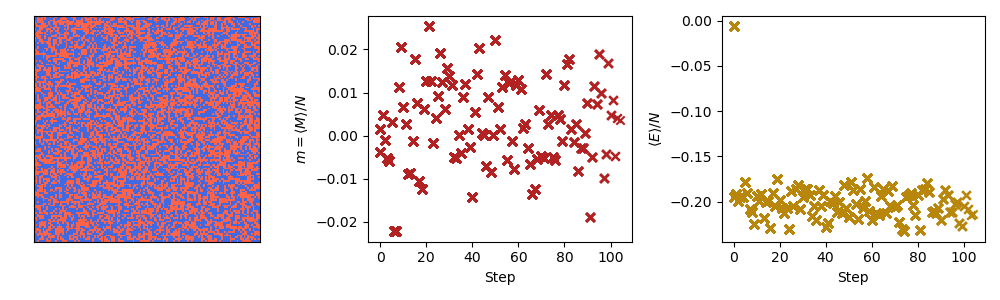

In [5]:
%matplotlib notebook

L=128                                                   # Side length of the square lattice
initial_spins = 2*np.random.randint(0,2,size=(L,L)) - 1 # Initial spin configuration of random +1 and -1

animate(initial_spins, beta=0.1)                        # Animate the system

<IPython.core.display.Javascript object>


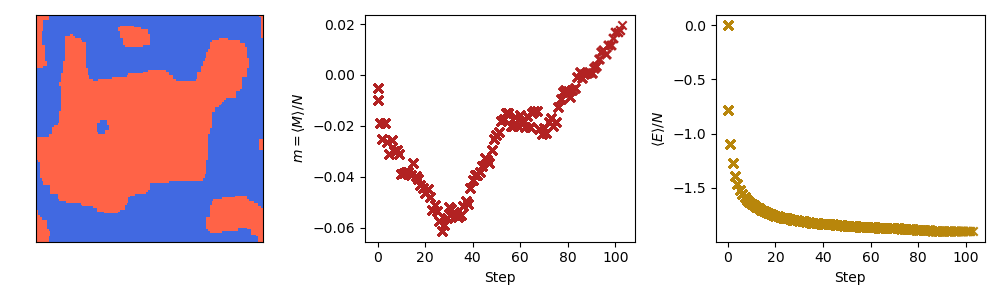

In [6]:
%matplotlib notebook

L=128                                                   # Side length of the square lattice
initial_spins = 2*np.random.randint(0,2,size=(L,L)) - 1 # Initial spin configuration of random +1 and -1

animate(initial_spins, beta=2)                          # Animate the system

<div class="alert alert-block alert-warning">
    
<b>Comment:</b> At high temperatures (i.e., low values of $\beta = 1/T$), the system looks "grainy", without any clear domains of up or down spins. This is reflected in the magnetisation and the average energy per spin, which are both on an average zero, since all of the spins flip their signs once per sweep, on an average.  
    
At low values of temperature, however, the spins seem to "coagulate" and form larger structures. The up and down clusters of spins are initially both of roughly the same size, but if we wait long enough, one cluster dominates. This leads to the magnetisation and internal energy both attaining non-zero values. Depending on which cluster dominates, the magnetisation can either be positive or negative, but it eventually plateaus out to +1 or -1 (depending on whether all the spins are pointing up or down). The internal energy per spin also behaves in a similar way, plateauing at different (negative) values based on the temperature. The fact that the internal energy is negative is not surprising, since spins within a cluster are pointed in the same direction, which is the "negative energy" configuration for a spin pair.

The transition between these two different types of behaviour seems to occur close to a value of $T=2.5$, which must therefore be an approximation to the "critical" temperature of this system.  
</div>

<div class="alert alert-block alert-info">
    
<b>Note:</b> My implementation of the `comparingLattices` function below takes around 10 minutes to run without `numba` for even small lattices `Ls=[4,8,16]`, and `n_mcs=10_000`. The same function runs in **6s** when using `numba`.  For interesting results you should do this for larger lattices, and for `n_mcs` greater than `5_000`, meaning that you should really get your code to work with `@njit`.
    
</div>

In [7]:
def comparingLattices(Ls=[4,8,16], colors=['navy', 'darkgreen', 'firebrick'], markers=['x','.','1']):
    '''
    Simulate square lattices of different side-lengths and produce graphs of the average energy per spin,
    average magnetisation per spin, specific heat and magnetic susceptibility.
    
    Parameters:
    -----------
    • Ls          : A list of different lattice lengths. (Default is [4,8,16].)
    • colors      : A list of colours to plot results for each lattice.  (Default is ['navy', 'darkgreen', 'firebrick'].)
    • markers     : A set of markers to plot results for each lattice. (Default is ['x', '.', '1'].)
    
    Returns:
    --------
    NoneType (A plot).
    '''
    
    if(len(Ls)>len(markers) or len(Ls)>len(colors)):
        raise ValueError("The `markers` and `colors` arrays should be atleast as long as the `Ls` array!")
        
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,8))  # Create a composite plot with 1 row and two columns.
                                                                # Each individual plot can be called using axes[0] and axes[1]
                                                                # If we had more than one row, axes would be 2D. i.e. we could 
                                                                # call the individual plots using axes[0][0] etc.
    # Parameters
    J = 1
    h = 0
    ############

    betas = np.linspace(0.3,0.7,20)                             # Range of betas over which to simulate the system
    
    avE   = np.zeros_like(betas)                                # Empty arrays to store the average and squared averages
    avEsq = np.zeros_like(betas)                                # of energy and magnetisation
    
    avM   = np.zeros_like(betas)
    avMsq = np.zeros_like(betas)
    
    for Li in tqdm(range(len(Ls))):                             # Loop over Ls. The `tqdm` function creates a progress-bar that auto-updates.
        L = Ls[Li]; N = L**2                                    # For each `L` in Ls
        
        for b_index in range(len(betas)):                       # For each beta in betas
            beta = betas[b_index]
            energy_array, m_array = simulate(L=L, beta=beta,h=h)# Simulate and store the appropriate values
            # The last 2/3 of the total values are taken for the averaging
            avE[b_index]   = np.mean(energy_array[2*len(energy_array)//3:])
            avEsq[b_index] = np.mean(energy_array[2*len(energy_array)//3:]**2)
            
            avM[b_index]   = np.mean(np.abs(m_array[2*len(m_array)//3:]))
            avMsq[b_index] = np.mean(m_array[2*len(m_array)//3:]**2)
        
        # Plotting the final graphs as a 4x4 tiled plot
        axes[0][0].scatter(betas,avE/N, color=colors[Li], marker=markers[Li], label=r"$(L="+str(L)+")$")
        axes[0][0].set_ylabel(r"$\langle E \rangle$ (per spin)")
        axes[0][0].set_xlabel(r"$\beta$")
        axes[0][0].legend()

        axes[0][1].scatter(betas, betas**2 * (avEsq-avE**2)/N, color=colors[Li], marker=markers[Li], label="$(L="+str(L)+")$")
        axes[0][1].set_ylabel(r"$c_V$")
        axes[0][1].set_xlabel(r"$\beta$")
        axes[0][1].legend()
        
        axes[1][0].scatter(betas,avM, color=colors[Li], marker=markers[Li], label=r"$(L="+str(L)+")$")
        axes[1][0].set_ylabel(r"$m = \langle M \rangle/N$")
        axes[1][0].set_xlabel(r"$\beta$")
        axes[1][0].legend()

        axes[1][1].scatter(betas, L**2*betas * (avMsq-avM**2), color=colors[Li], marker=markers[Li], label="$(L="+str(L)+")$")
        axes[1][1].set_ylabel(r"$\chi$")
        axes[1][1].set_xlabel(r"$\beta$")
        axes[1][1].legend()

<IPython.core.display.Javascript object>


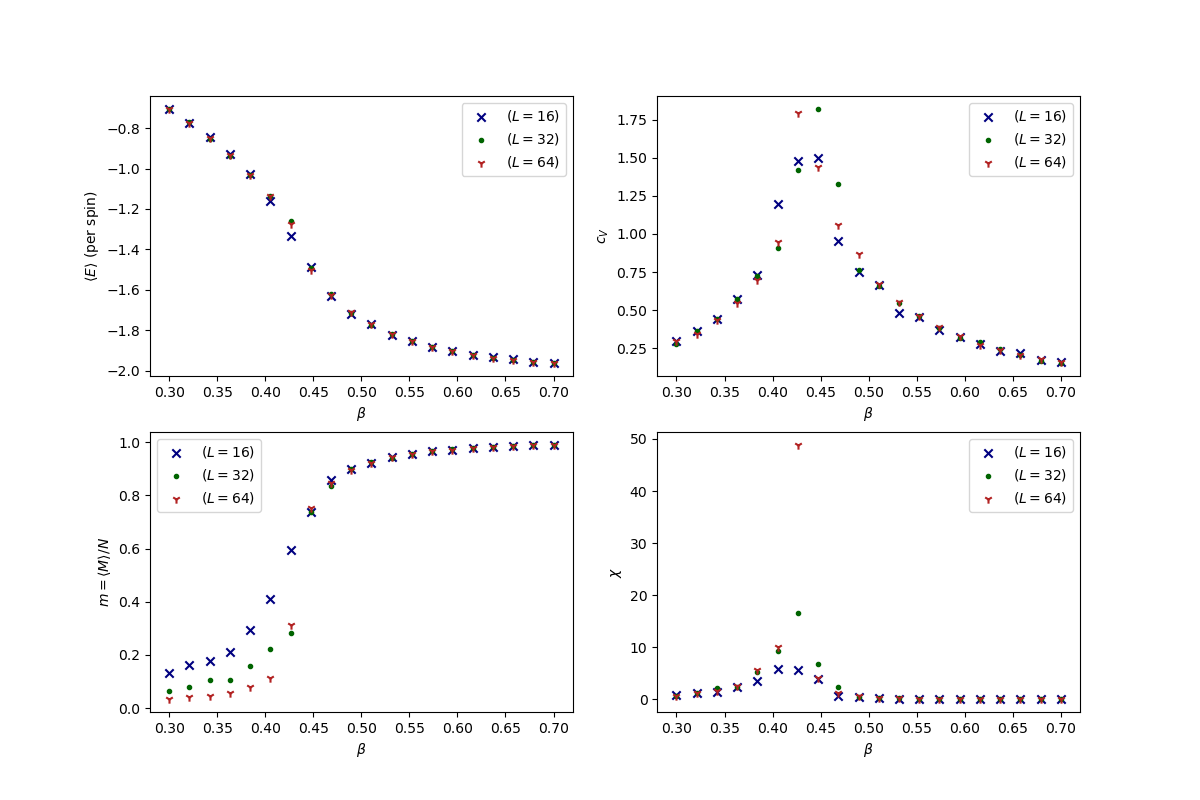

100%|█████████████████████████████████████████████████████████████████| 3/3 [00:27<00:00,  9.26s/it]

CPU times: user 27.4 s, sys: 259 ms, total: 27.6 s
Wall time: 27.9 s


In [8]:
%%time
# The default values should take around 10 minutes to run without Numba, and 6 seconds to run with it.

comparingLattices(Ls=[16,32,64])

<div class="alert alert-block alert-warning">
<b>Comments:</b> All four of the above graphs show something interesting occuring when $T=2.269=T_c$, which corresponds to $\beta = 0.44$. 

* _Internal energy per spin_ $\langle E \rangle/ N$: The general behaviour of this graph is the same as what was seen in the animation. However, Wwhile this curve is smooth, $T=T_c$ seems to be a point with the highest slope, indicating that something interesting must be happening to the derivative of $\langle E \rangle$ (which is just the specific heat $c_V$) at $T=T_c$.

<br/>
    
* _Specific heat_ $c_V$: As expected, at $T=T_c$ the specific heat peaks. What is less obvious is that on either side of $T=T_c$, the slope of the specific heat is different, meaning that its derivative is discontinuous at that point.

<br/>

* _Magnetisation per spin_ $\langle M \rangle/N$: Note that we are actually plotting the absolute value of $|\langle M \rangle|$ per spin, so that the two scenarios where the positive and where the negative clusters dominate are treated equally. Therefore, at low temperatures (high $\beta$) all lattices seem to converge to the same value of magnetisation per spin, which is close to +1. On the other hand, at higher temperatures, this curve drops to zero, but the speed with which this happens depends on the lattice size; larger lattices drop much faster. Naively interpolating, one would expect the steepest drop to occur in the thermodynamic limit, where the magnetisation per spin would go from a zero to a non-zero value in a piece-wise continuous way. Of course, this would imply that in the thermodynamic limit, the magnetic susceptibility (the derivative of the magnetisation) should blow up at $T=T_c$.

<br/>

* _Magnetic susceptibility_ $\chi$: As expected, the magnetic susceptibility also shows signs of misbehaving at $T=T_c$. As the size of the lattice increases, so does the height of this peak. Although a more detailed ("finite size scaling") analysis is needed, a reasonable claim would be predict that the peak is proportional to some power of the total number of spins $N$. In this case, in the thermodynamic limit (i.e., as $N\to\infty$), this quantity would blow up, a signature of a _second order phase transition_.
</div>